<a href="https://colab.research.google.com/github/vsoumyareddy/CODSOFT/blob/main/Fraud_Detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fraud-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F817870%2F1399887%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240414%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240414T101220Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2ad4a576f10832bfb756f776fdc4e2326cae483acb163425ca6d414c8c47152073c1a2c8e4d702dca4f6d682d031cabfd7e5d849e8c42fb443a2625d33ba48ebec53d29ce4e6429746e359025670d293b9ebfc5e8bc8f45608ed27348de68f11100195c0618a3aaebfc882c901f5463c2203209f310ab6e989dfe9e3b426081d7aaaeafb1e092358170330fbf5f4d858498332f6a1c084c84e977dc1bfc6ad475c051a8bf4109b7713d9482c97c1f3f0c6c694fa155184ca987b1642900a5e89d638255357b09947c23e903f95608ebd19468cd390892b291ea69841e6267031b2dfc43919a509f5766fdd08d5fc2e8a684355f818acf06a7735bcf08c778067'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 211766662 bytes downloaded
Downloaded and uncompressed: fraud-detection
Data source import complete.


In [113]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  classification_report
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score)

In [111]:
import warnings
warnings.filterwarnings('ignore')

IMPORT OF DATA

In [83]:
df_train = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv')
df_test = pd.read_csv('/kaggle/input/fraud-detection/fraudTest.csv')

In [84]:
df_train.shape, df_test.shape

((1296675, 23), (555719, 23))

COMBINE OF DATA WITH TRAIN AND TEST

In [85]:
list(df_train.columns) == list(df_test.columns)

True

In [86]:
df = pd.concat([df_train, df_test])

In [87]:
df.shape

(1852394, 23)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud               i

REMOVE UNNECESSARY DATA -DATA CLEANING

In [89]:
df =df.drop(['cc_num','first', 'last', 'street', 'city', 'state', 'zip', 'dob','merchant' ,'job','trans_num','trans_date_trans_time'],axis=1)

ENCODER

In [125]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
# Fit and transform the 'category' column
df['category'] = encoder.fit_transform(df[['category']])
df['gender'] = encoder.fit_transform(df[['gender']])


PLOT OF FRAUD AND CATEGORY

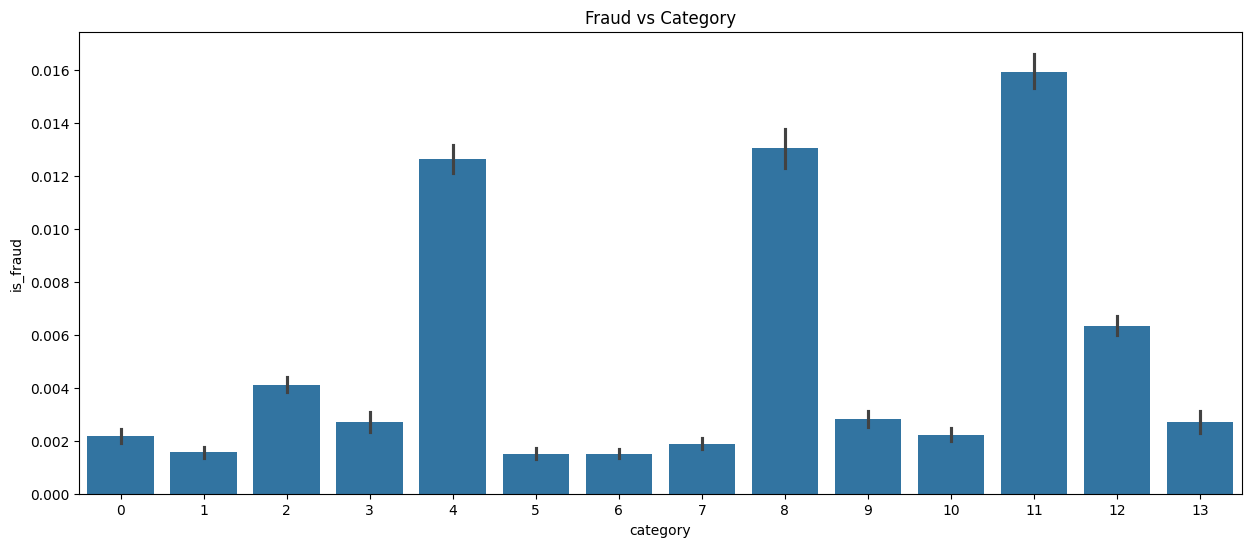

In [93]:

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 6))
sns.barplot(x = 'category', y = 'is_fraud', data = df)
plt.title('Fraud vs Category')
plt.show()


In [95]:
df.head(5)

,Unnamed: 0,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
0,0,8,4.97,0,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0
1,1,4,107.23,0,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0
2,2,0,220.11,1,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0
3,3,2,45.00,1,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0
4,4,9,41.96,1,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 555718
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   category    int64  
 2   amt         float64
 3   gender      int64  
 4   lat         float64
 5   long        float64
 6   city_pop    int64  
 7   unix_time   int64  
 8   merch_lat   float64
 9   merch_long  float64
 10  is_fraud    int64  
dtypes: float64(5), int64(6)
memory usage: 169.6 MB


TRAIN AND TEST

In [98]:
x = df.drop(columns=['is_fraud'])
y = df['is_fraud']

In [99]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

TOTAL FRAUD PERCENTAGE

In [100]:
fraudulent_count = df['is_fraud'].sum()
legitimate_count = len(df) - fraudulent_count

# Calculate the percentage of fraudulent and legitimate transactions
total_transactions = len(df)
fraudulent_percentage = (fraudulent_count / total_transactions) * 100
legitimate_percentage = (legitimate_count / total_transactions) * 100

print("Fraudulent transactions: {} ({:.2f}%)".format(fraudulent_count, fraudulent_percentage))
print("Legitimate transactions: {} ({:.2f}%)".format(legitimate_count, legitimate_percentage))

Fraudulent transactions: 9651 (0.52%)
Legitimate transactions: 1842743 (99.48%)


LOGISTIC REEGRESSION

In [101]:
lr_1 = LogisticRegression()
lr_1.fit(x_train, y_train)
accuracy_score(y_train, lr_1.predict(x_train))

0.9948229124491488

In [102]:
accuracy_score(y_test, lr_1.predict(x_test))

0.9947131553896843

In [115]:
report = classification_report(y_test, lr_1.predict(x_test))
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    552781
           1       0.00      0.00      0.00      2938

    accuracy                           0.99    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      0.99      0.99    555719



In [114]:
table_1 = {}
table_1["LOGISTIC REGRESSION"] = (accuracy_score(y_test, lr_1.predict(x_test)),
                               precision_score(y_test, lr_1.predict(x_test), average='micro'),
                               recall_score(y_test, lr_1.predict(x_test), average='micro'),
                               f1_score(y_test, lr_1.predict(x_test), average='micro'))

DECISION TREE

In [104]:
dt_1= DecisionTreeClassifier()
dt_1.fit(x_train, y_train)
accuracy_score(y_train, dt_1.predict(x_train))

1.0

In [105]:
accuracy_score(y_test, dt_1.predict(x_test))

0.9962768953373917

In [116]:
report = classification_report(y_test, dt_1.predict(x_test))
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552781
           1       0.64      0.67      0.66      2938

    accuracy                           1.00    555719
   macro avg       0.82      0.83      0.83    555719
weighted avg       1.00      1.00      1.00    555719



In [120]:
table_1["DECISION TREE"] = (accuracy_score(y_test, dt_1.predict(x_test)),
                               precision_score(y_test, dt_1.predict(x_test), average='micro'),
                               recall_score(y_test, dt_1.predict(x_test), average='micro'),
                               f1_score(y_test, dt_1.predict(x_test), average='micro'))

RANDOM FOREST

In [119]:
from sklearn.ensemble import RandomForestClassifier
rf_1 = RandomForestClassifier()
rf_1.fit(x_train, y_train)
accuracy_score(y_train, rf_1.predict(x_train))

0.9999984575934602

In [121]:
accuracy_score(y_test, rf_1.predict(x_test))

0.9976642871667155

In [122]:
report = classification_report(y_test, rf_1.predict(x_test))
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552781
           1       0.86      0.67      0.75      2938

    accuracy                           1.00    555719
   macro avg       0.93      0.83      0.88    555719
weighted avg       1.00      1.00      1.00    555719



In [123]:
table_1["RANDOM FOREST"] = (accuracy_score(y_test, rf_1.predict(x_test)),
                               precision_score(y_test, rf_1.predict(x_test), average='micro'),
                               recall_score(y_test, rf_1.predict(x_test), average='micro'),
                               f1_score(y_test, rf_1.predict(x_test), average='micro'))

In [124]:
pd.DataFrame(table_1, index=["accuracy", "precision", "recall", "f1score"])

,LOGISTIC REGRESSION,DECISION TREE,RANDOM FOREST
accuracy,0.994713,0.996277,0.997664
precision,0.994713,0.996277,0.997664
recall,0.994713,0.996277,0.997664
f1score,0.994713,0.996277,0.997664
